# Data attributes

In [35]:
import bpy
from IPython.display import display, Image

def fresh_scene():
    # Deselect all objects
    bpy.ops.object.select_all(action='DESELECT')
    # Select all objects except cameras
    for obj in bpy.context.scene.objects:
        if  obj.type != 'CAMERA':
            obj.select_set(True)
        else:
            obj.select_set(False)
    bpy.ops.object.delete()
    
    # add light
    bpy.ops.object.light_add(type='SUN')
    sun = bpy.context.object

    sun.location = (0, 0, 0)
    from math import radians
    sun.rotation_euler = (radians(204), radians(-133), radians(-67))
    sun.data.energy = 5  


def render_result():
    bpy.ops.render.render()
    bpy.data.images['Render Result'].save_render(filepath="img.png")
    display(Image(filename="img.png"))

bpy.context.scene.render.resolution_x = 500
bpy.context.scene.render.resolution_y = 200

In [36]:
# temp
bpy.ops.wm.save_as_mainfile(filepath="scene.blend")

Info: Saved "scene.blend"


{'FINISHED'}

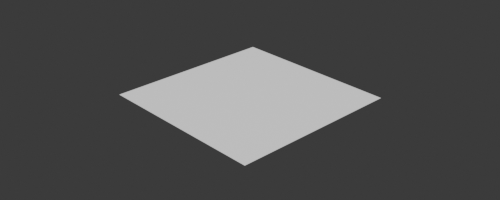

In [37]:
fresh_scene()
bpy.ops.mesh.primitive_plane_add(size=3, location=(0, 0, 0))  
plane = bpy.context.object

render_result()

In [38]:
num_vertices = len(plane.data.vertices)
num_vertices

4

In [39]:
vertices = [(v.co.x, v.co.y, v.co.z) for v in plane.data.vertices]
import pandas as pd
df = pd.DataFrame(vertices, columns=['X', 'Y', 'Z'])
df

,X,Y,Z
0,-1.5,-1.5,0.0
1,1.5,-1.5,0.0
2,-1.5,1.5,0.0
3,1.5,1.5,0.0


# Adding a Float

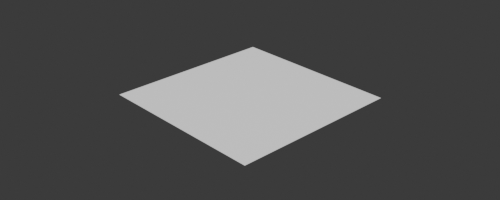

In [40]:
attr_name = 'my_float'

# 'POINT' domain means each vertex gets the value
attr = plane.data.attributes.new(name=attr_name,type='FLOAT',domain='POINT')

values = [2.0, 3.0, 4.2, 5.2]
attr.data.foreach_set('value', values)
plane.data.update()

render_result()

In [41]:
# we can confirm this by checking with a dataframe:
df = pd.DataFrame({
    'X': [v.co.x for v in plane.data.vertices],
    'Y': [v.co.y for v in plane.data.vertices],
    'Z': [v.co.z for v in plane.data.vertices],
    'my_float': [val.value for val in plane.data.attributes['my_float'].data]
})

df

,X,Y,Z,my_float
0,-1.5,-1.5,0.0,2.0
1,1.5,-1.5,0.0,3.0
2,-1.5,1.5,0.0,4.2
3,1.5,1.5,0.0,5.2


# Now let's use the attribute in Geometry Nodes!

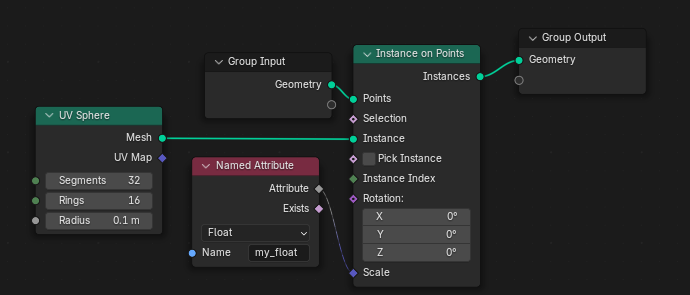

In [42]:
blend_file_path = "cube_gn_attribute.blend"
node_group_name = "gn_place_by_attribute"

# Load only the node group from the blend file
with bpy.data.libraries.load(blend_file_path, link=False) as (data_from, data_to):
    if node_group_name in data_from.node_groups:
        data_to.node_groups = [node_group_name]

# Access the node group
node_group_place_spheres_attributes = bpy.data.node_groups[node_group_name]

# Print all the node names inside the node group
print(f"Nodes in node group '{node_group_name}':")
for node in node_group_place_spheres_attributes.nodes:
    print(node.name)

Nodes in node group 'gn_place_by_attribute':
Group Input
Group Output
Instance on Points
Named Attribute
UV Sphere


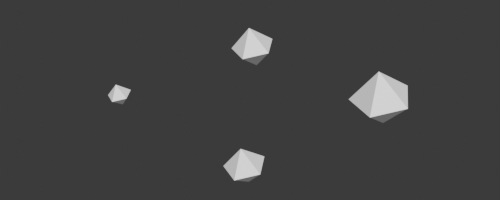

In [43]:
# add geometry nodes
modifier = plane.modifiers.new(name="GeometryNodes", type='NODES')
modifier.node_group = node_group_place_spheres_attributes
plane.data.update()

render_result()

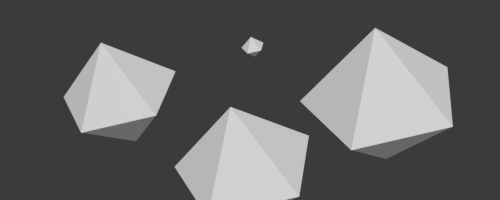

In [44]:
values = [10.0, 10.0, 2.2, 13.2]
attr.data.foreach_set('value', values)
plane.data.update()

render_result()

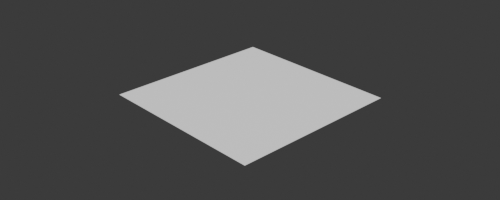

In [45]:
# remove geometry nodes modifier again
modifier = plane.modifiers.get("GeometryNodes")
plane.modifiers.remove(modifier)
render_result()

In [46]:
# Other datatypes are:# 'FLOAT', 'INT', 'FLOAT_VECTOR', 'FLOAT_COLOR', 'BYTE_COLOR', 'STRING', 'BOOLEAN', 'FLOAT2', 'INT8', 'INT32_2D', 'QUATERNION', 'FLOAT4X4


# Add INT

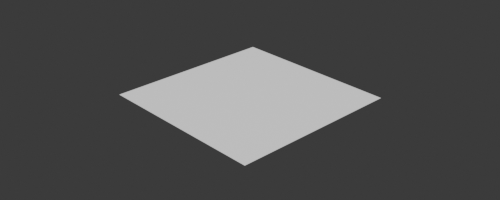

In [47]:
if 'my_int' in plane.data.attributes:
    plane.data.attributes.remove(plane.data.attributes['my_int'])

# 'POINT' domain means each vertex gets the value
attr = plane.data.attributes.new(name="my_int",type='INT',domain='POINT')
values = [2, 3, 4, 2]
attr.data.foreach_set('value', values)
plane.data.update()
render_result()

# ADD COLOR

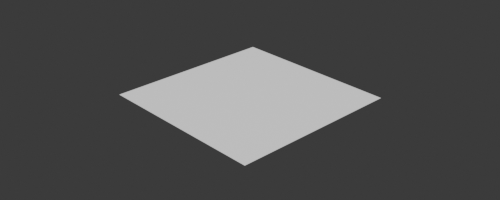

In [48]:
if 'my_color' in plane.data.attributes:
    plane.data.attributes.remove(plane.data.attributes['my_color'])

attr = plane.data.attributes.new(name='my_color', type='FLOAT_COLOR', domain='POINT')
values = [
    (1.0, 0.5, 0.0, 1.0), # "Orange 1
    (1.0, 0.4, 0.1, 1.0), # "Orange 2
    (1.0, 0.3, 0.2, 1.0), # "Orange 3
    (1.0, 0.2, 0.1, 1.0), # "Orange 4
]
for i, color in enumerate(values):
    attr.data[i].color = color

plane.data.update()
render_result()

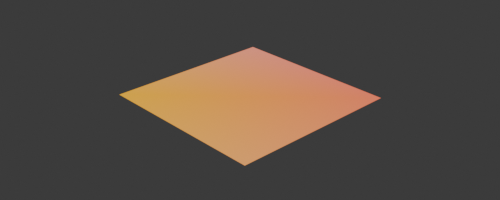

In [49]:
# add shader nodes
material = bpy.data.materials.new(name="MyMaterial")
material.use_nodes = True

nodes = material.node_tree.nodes
links = material.node_tree.links

for node in nodes:
    nodes.remove(node)

attribute_node = nodes.new(type="ShaderNodeAttribute")
attribute_node.location = (-600, 0)
attribute_node.attribute_name = "my_color"

principled_node = nodes.new(type="ShaderNodeBsdfPrincipled")
principled_node.location = (-200, 0)

output_node = nodes.new(type="ShaderNodeOutputMaterial")
output_node.location = (200, 0)

links.new(attribute_node.outputs['Color'], principled_node.inputs['Base Color'])
links.new(principled_node.outputs['BSDF'], output_node.inputs['Surface'])

# Ensure the object has at least one material slot
if len(plane.data.materials) == 0:
    plane.data.materials.append(material)
else:
    plane.data.materials[0] = material

render_result()

In [50]:
# Add vector attribute

if 'my_vector' in plane.data.attributes:
    plane.data.attributes.remove(plane.data.attributes['my_vector'])

attr = plane.data.attributes.new(name='my_vector', type='FLOAT_VECTOR', domain='POINT')
values = [
    (0.4, 0.4, -1.0),
    (0.2, 0.3, 0.9),
    (0.5, 0.5, 0.5),
    (0.6, 0.9, 1.3)
]
for i, vector in enumerate(values):
    attr.data[i].vector = vector

plane.data.update()

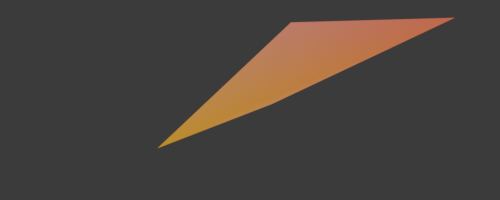

In [51]:

geo_nodes = plane.modifiers.new(name="GeometryNodes", type="NODES")

node_group = bpy.data.node_groups.new(name="GeometryNodes", type="GeometryNodeTree")
geo_nodes.node_group = node_group

group_input = node_group.nodes.new(type="NodeGroupInput")
group_input.location = (0, 0)

group_output = node_group.nodes.new(type="NodeGroupOutput")
group_output.location = (600, 0)

node_group.interface.new_socket(name="Geometry", in_out="INPUT", socket_type="NodeSocketGeometry")
node_group.interface.new_socket(name="Geometry", in_out="OUTPUT", socket_type="NodeSocketGeometry")

set_position = node_group.nodes.new(type="GeometryNodeSetPosition")
set_position.location = (300, 0)

named_attribute = node_group.nodes.new(type="GeometryNodeInputNamedAttribute")
named_attribute.location = (100, -200)
named_attribute.data_type = 'FLOAT_VECTOR'
named_attribute.inputs["Name"].default_value = "my_vector"

node_group.links.new(group_input.outputs["Geometry"], set_position.inputs["Geometry"])
node_group.links.new(set_position.outputs["Geometry"], group_output.inputs["Geometry"])

node_group.links.new(named_attribute.outputs["Attribute"], set_position.inputs["Offset"])

render_result()

In [52]:
import pandas as pd
import bpy

# Assume you are working with the plane object
plane = bpy.data.objects['Plane']

# Create the DataFrame for coordinates
df = pd.DataFrame({
    'X': [v.co.x for v in plane.data.vertices],
    'Y': [v.co.y for v in plane.data.vertices],
    'Z': [v.co.z for v in plane.data.vertices]
})

# Add custom attributes if they exist

# Add my_float attribute
if 'my_float' in plane.data.attributes:
    df['my_float'] = [attr.value for attr in plane.data.attributes['my_float'].data]

# Add my_int attribute
if 'my_int' in plane.data.attributes:
    df['my_int'] = [attr.value for attr in plane.data.attributes['my_int'].data]

# Add my_color attribute and round to 2 decimal places
if 'my_color' in plane.data.attributes:
    df['my_color'] = [tuple(round(c, 3) for c in attr.color) for attr in plane.data.attributes['my_color'].data]

# Add my_vector attribute
if 'my_vector' in plane.data.attributes:
    df['my_vector'] = [tuple(round(c, 3) for c in attr.vector) for attr in plane.data.attributes['my_vector'].data]

# Display the DataFrame
df

,X,Y,Z,my_float,my_int,my_color,my_vector
0,-1.5,-1.5,0.0,10.0,2,"(1.0, 0.5, 0.0, 1.0)","(0.4, 0.4, -1.0)"
1,1.5,-1.5,0.0,10.0,3,"(1.0, 0.4, 0.1, 1.0)","(0.2, 0.3, 0.9)"
2,-1.5,1.5,0.0,2.2,4,"(1.0, 0.3, 0.2, 1.0)","(0.5, 0.5, 0.5)"
3,1.5,1.5,0.0,13.2,2,"(1.0, 0.2, 0.1, 1.0)","(0.6, 0.9, 1.3)"


#  Vertex, Face and Edge domain

Vertex


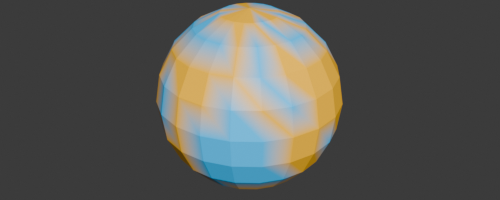

In [53]:
import random
material = bpy.data.materials.new("MyMaterial")
material.use_nodes = True
nodes = material.node_tree.nodes
links = material.node_tree.links
nodes.clear()
attr_node = nodes.new("ShaderNodeAttribute")
bsdf_node = nodes.new("ShaderNodeBsdfPrincipled")
output_node = nodes.new("ShaderNodeOutputMaterial")
links.new(attr_node.outputs['Color'], bsdf_node.inputs['Base Color'])
links.new(bsdf_node.outputs['BSDF'], output_node.inputs['Surface'])


print("Vertex")
fresh_scene()
bpy.ops.mesh.primitive_uv_sphere_add(radius=1.5, segments=20, ring_count=10)
obj = bpy.context.object
mesh = obj.data
attr_name = 'my_point_color'
attr = mesh.attributes.new(attr_name, 'FLOAT_VECTOR', 'POINT')
colors = [c for _ in mesh.vertices for c in random.choice([(1, 0.5, 0), (0, 0.5, 1)])]
attr.data.foreach_set('vector', colors)
mesh.update()
attr_node.attribute_name = attr_name
obj.data.materials.append(material)
render_result()

Face


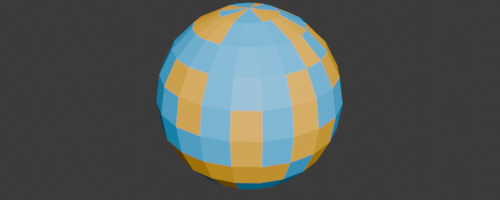

In [54]:
print("Face")
fresh_scene()
bpy.ops.mesh.primitive_uv_sphere_add(radius=1.5, segments=20, ring_count=10)
obj = bpy.context.object
mesh = obj.data
attr_name = 'my_color'
attr = mesh.attributes.new(attr_name, 'FLOAT_VECTOR', 'FACE')
colors = [c for _ in mesh.polygons for c in random.choice([(1, 0.5, 0), (0, 0.5, 1)])]
attr.data.foreach_set('vector', colors)
mesh.update()
attr_node.attribute_name = attr_name
obj.data.materials.append(material)
render_result()

Edge


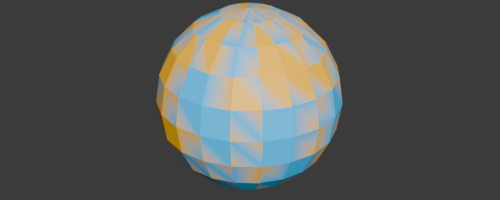

In [55]:
print("Edge")
fresh_scene()
bpy.ops.mesh.primitive_uv_sphere_add(radius=1.5, segments=20, ring_count=10)
obj = bpy.context.object
mesh = obj.data
attr_name = 'my_edge_color'
attr = mesh.attributes.new(attr_name, 'FLOAT_VECTOR', 'EDGE')
colors = [c for _ in mesh.edges for c in random.choice([(1, 0.5, 0), (0, 0.5, 1)])]
attr.data.foreach_set('vector', colors)
mesh.update()
attr_node.attribute_name = attr_name
obj.data.materials.append(material)
render_result()
